# Quantum Approximate Optimization Algorithm using Gate-based QC

This notebook consists of a implementation of multi anlge QAOA (or ma-QAOA) using Pennylane.

In [5]:
# Importing required libraries

# General imports
import time
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

# Libraries for Model Formulation
from docplex.mp.model import Model
from scipy.optimize import minimize
import scipy

# Qiskit Imports
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

# Library for circuit simulation
import pennylane as qml

import networkx as nx

## Building the model and its Cost Function 
We are using ***docplex*** to build the model and calculate $Q$ and $c$.

In [6]:
def build_qubo(arr: list):

    n = len(arr)
    c = sum(arr)
    # Building the model and its QUBO formulation.
    model = Model()
    x = model.binary_var_list(n)

    Q =  (c - 2*sum(arr[i]*x[i] for i in range(n)))**2
    model.minimize(Q)   

    problem = from_docplex_mp(model)

    converter = QuadraticProgramToQubo()
    qubo = converter.convert(problem)
    # print(qubo)

    quadratics = qubo.objective.quadratic.coefficients
    linears = qubo.objective.linear.coefficients

    return quadratics, linears, qubo

# Function to sort the count dictionary.
def find_most_common_solutions(input_dict, n):
    sorted_keys = sorted(input_dict, key=input_dict.get, reverse=True)
    return sorted_keys[:n]

In [7]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes()
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")


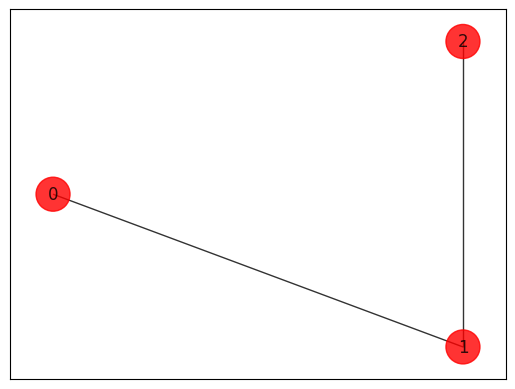

In [8]:
# Initializing a Graph Instance.

# Generating a graph of 3 nodes
# Nodes in the Graph.
n = 3  # Number of nodes in graph
G3 = nx.Graph()
G3.add_nodes_from(np.arange(0, n, 1))

# Edges in the Graph.
edges = [(0, 1, 1.0), (1, 2, 1.0)]
G3.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["r" for node in G3.nodes()]
pos_3 = nx.shell_layout(G3)

draw_graph(G3, colors, pos_3)

In [9]:
for i,j, in G3.edges():
    print(i,j)

0 1
1 2


In [25]:
def flat_index(n: int, i: int, j: int) -> int:
    '''Returns the flat index of the matrix given the row and column indices.'''
    return int(n*i + j)

In [12]:
def build_qubo_maxcut(graph: nx.Graph):

    n_nodes = graph.number_of_nodes()
    edges = graph.edges()

    
    model = Model()
    x = model.binary_var_list(n_nodes)

    Q = sum(graph.get_edge_data(i,j).get('weight')*x[i]*(1-x[j]) for i,j in edges)

    model.minimize(Q)

    problem = from_docplex_mp(model)
    converter = QuadraticProgramToQubo()
    qubo = converter.convert(problem)

    quadratics = np.zeros((n_nodes,n_nodes))
    for edge_i in range(n_nodes):
        for edge_j in range(n_nodes):
            if (edge_i,edge_j) in edges:
                quadratics[edge_i,edge_j] = graph.get_edge_data(edge_i,edge_j).get('weight')

    return quadratics, qubo

## Creating the QAOA circuit and layers.

I'm using ***Pennylane*** to handle the circuit simulations. I have created functions to generate the QAOA circuit given $Q$ and $c$.

In [22]:

arr = np.array([[1, 2, 3, 4], [5, 6, 7, 8]])

for (i,dx), x in np.ndenumerate(arr):
  print(i,dx, x) 

0 0 1
0 1 2
0 2 3
0 3 4
1 0 5
1 1 6
1 2 7
1 3 8


In [48]:
# Defining the Cost and the Layers of ma-QAOA.

# Cost Layer for Maxcut.
def U_C(gamma:np.array,quadratics:np.array,num_qubits:int):
    gamma_count = 0
    for (wire1, wire2),_ in np.ndenumerate(quadratics):
        if wire1<wire2:
            qml.CNOT(wires=[wire1, wire2])
            qml.RZ(1/4*quadratics[(wire1, wire2)]*gamma[gamma_count],wires=wire2)
            qml.CNOT(wires=[wire1, wire2])
            gamma_count += 1
    return None

# Mixer Layer.
def U_M(betas:np.array,num_qubits:int):
    for qubit in range(num_qubits):
        qml.RX(2*betas[qubit],wires=qubit)
    return None

In [51]:
# Function to generate the QAOA circuit given the parameters and coefficients.
def qaoa_circuit_generator(num_qubits,layers,gammas,betas,quadratics):
    # Defining the QAOA circuit.
    dev = qml.device("lightning.qubit", wires=num_qubits, shots=1024)
    @qml.qnode(dev)
    def circuit(gammas,betas,quadratics):

        n_gammas = int(num_qubits*(num_qubits-1)/2)

        for qubit in range(num_qubits):
            qml.Hadamard(wires=qubit)
        qml.Barrier()
        print(gammas.shape)
        for layer in range(layers):
            U_C(gammas[layer*n_gammas:(layer+1)*n_gammas],quadratics,num_qubits)
            qml.Barrier()
            U_M(betas[layer*num_qubits:(layer+1)*num_qubits],num_qubits)
            qml.Barrier()

        return qml.counts(wires=range(num_qubits))

    return circuit(gammas,betas,quadratics)

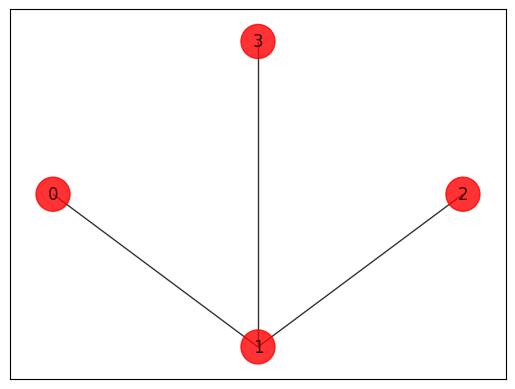

In [46]:
# Generating a graph of 4 nodes
# Nodes in the Graph.
n = 4  # Number of nodes in graph
G4 = nx.Graph()
G4.add_nodes_from(np.arange(0, n, 1))

# Edges in the Graph.
edges = [(0, 1, 1.0), (1, 2, 1.0), (1, 3, 1.0)]
G4.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["r" for node in G4.nodes()]
pos_4 = nx.shell_layout(G4)

draw_graph(G4, colors, pos_4)

(6,)
Function call: 1 - Cost: 2.0
(6,)
Function call: 2 - Cost: 2.0
(6,)
Function call: 3 - Cost: 1.0
(6,)
Function call: 4 - Cost: 0.0
(6,)
Function call: 5 - Cost: 0.0
(6,)
Function call: 6 - Cost: 0.0
(6,)
Function call: 7 - Cost: 0.0
(6,)
Function call: 8 - Cost: 0.0
(6,)
Function call: 9 - Cost: 1.0
(6,)
Function call: 10 - Cost: 0.0
(6,)
Function call: 11 - Cost: 2.0
(6,)
Function call: 12 - Cost: 0.0
(6,)
Function call: 13 - Cost: 0.0
(6,)
Function call: 14 - Cost: 0.0
(6,)
Function call: 15 - Cost: 0.0
(6,)
Function call: 16 - Cost: 2.0
(6,)
Function call: 17 - Cost: 0.0
(6,)
Function call: 18 - Cost: 2.0
(6,)
Function call: 19 - Cost: 0.0
(6,)
Function call: 20 - Cost: 2.0
(6,)
Function call: 21 - Cost: 1.0
(6,)
Function call: 22 - Cost: 2.0
(6,)
Function call: 23 - Cost: 1.0
(6,)
Function call: 24 - Cost: 0.0
(6,)
Function call: 25 - Cost: 0.0
(6,)
Function call: 26 - Cost: 0.0
(6,)
Function call: 27 - Cost: 0.0
(6,)
Function call: 28 - Cost: 1.0
(6,)
Function call: 29 - Cost

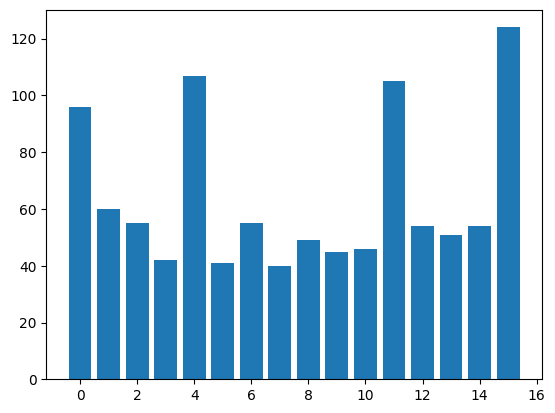

In [53]:
func_call = 0
theta = []
cost = []

def callback_func(x):
    theta.append(x)

def qaoa(graph: nx.Graph,layers:int):

    quadratics, qubo = build_qubo_maxcut(graph)
    num_qubits = graph.number_of_nodes()

    # n_gammas = G3.number_of_edges()
    n_gammas = int(num_qubits*(num_qubits-1)/2)
    
    # Initial guess
    init_gamma = np.array([pi/1.5]*n_gammas*layers)
    init_beta = np.array([pi/4]*num_qubits*layers)

    initial_guess = np.concatenate((init_gamma, init_beta))
    
    def expectation_value(theta):

        global func_call 
        func_call = func_call + 1

        sep = int(n_gammas*layers)
        gammas = theta[:sep]
        betas = theta[sep:]

        counts = qaoa_circuit_generator(num_qubits, layers, gammas, betas, quadratics)
        best_sol = max(counts, key=counts.get)

        exp = qubo.objective.evaluate(np.array(list(best_sol), dtype='int'))
        cost.append(-1*exp)

        print(f'Function call: {func_call} - Cost: {exp}')

        return -1*exp


    # Minimization of the objective function.
    start_time = time.time()
    res = minimize(expectation_value, initial_guess, method='COBYLA',callback=callback_func)
    # res = minimize(expectation_value, initial_guess, method='BFGS')
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f'Elapsed time for QAOA: {elapsed_time} seconds')
    
    sep = int(n_gammas*layers)

    prime_gammas = res.x[:sep]
    prime_betas = res.x[sep:]

    print(f'Gammas: {prime_gammas}\nBetas: {prime_betas}')

    counts = qaoa_circuit_generator(num_qubits, layers,prime_gammas, prime_betas, quadratics)
    
    return counts

# Defining a test array
layers = 1

# Running QAOA on for Number Partitioning. 
counts = qaoa(G4,layers)

print(f"Counts:\n{counts}\n")

# Potting
plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.show()

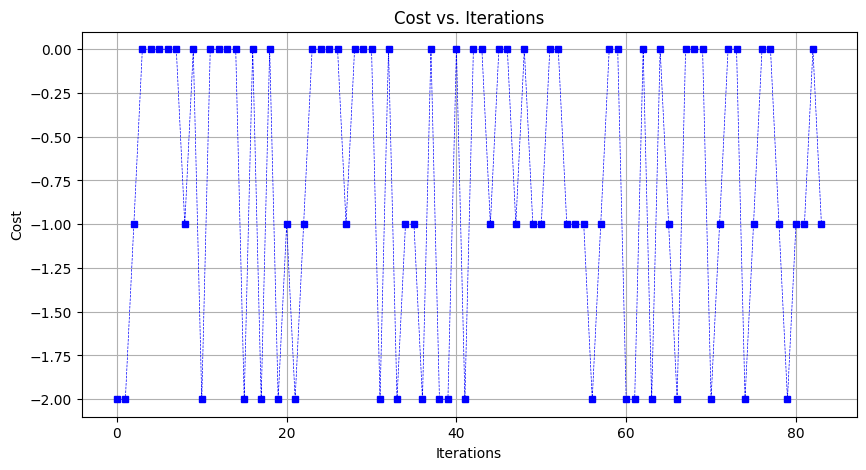

In [54]:
# Plotting Cost vs. Iterations

plt.figure(figsize=(10, 5),dpi=100)
plt.plot(range(len(cost)),cost,c='blue',ls='--',lw=0.5,marker='s',ms=4)
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs. Iterations')
plt.show()

In [55]:
def print_solution_npp(counts):
    
    # Printing Solutions Sets.
    best_sol = find_most_common_solutions(counts,3)
    print(f'\n\nTop 3 solutions for the array {test_array} and {layers} layers: \n{best_sol}')

    # Calculating S and S_A
    S = []
    S_A = []
    for ind,bit in enumerate(best_sol[0]):
        if bit == '1':
            S.append(ind)
        else:
            S_A.append(ind)

    # Calculating Sum(S) and Sum(S/A)
    sum_S = sum(np.array(test_array)[S])
    sum_S_A = sum(np.array(test_array)[S_A])

    # Printing the best optimal partition.
    print(f'\nBest Partition:\nS: {np.array(test_array)[S]}\nSum(S) = {sum_S}\n\nS/A: {np.array(test_array)[S_A]}\nSum(S/A) = {sum_S_A}')
    return None

In [60]:
def print_solution_maxcut(graph: nx.Graph, counts: dict) -> None:
    
    # Printing Solutions Sets.
    best_sol = find_most_common_solutions(counts,3)
    print(f'\n\nTop 3 solutions for the graph {graph} and {layers} layers: \n{best_sol}')

    def plot_solution(G,pos,results):
        c = ["r" if b == "0" else "c" for b in find_most_common_solutions(results, 1)[0]]
        draw_graph(G, c, pos)

    pos = nx.spring_layout(graph)
    plot_solution(graph,pos,counts)

    return None



Top 3 solutions for the graph Graph with 4 nodes and 3 edges and 1 layers: 
['1111', '0100', '1011']


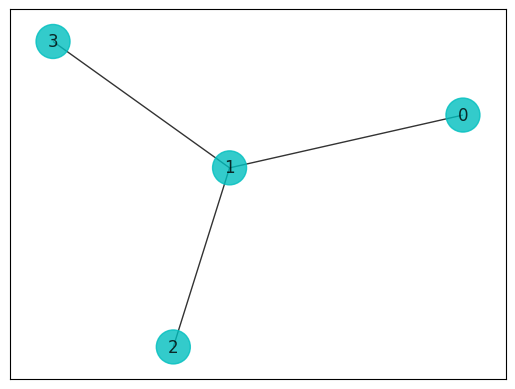

In [61]:
print_solution_maxcut(G4,counts)